<a href="https://colab.research.google.com/github/polinaproskura/NLP_ensembles/blob/main/BERT_ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка моделей и данных

In [ ]:
from IPython.display import clear_output
! pip install datasets
! pip install transformers[torch]
! pip install bayesian-optimization
! pip install cvxopt
! pip install qpsolvers==3.4.0
! pip install accelerate==0.20.1 -U
! pip install git+https://github.com/simonzhang00/ripser-plusplus.git
! pip install git+https://github.com/IlyaTrofimov/RTD.git
clear_output()

In [ ]:
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer, set_seed
from sklearn.metrics import accuracy_score
from datasets import load_dataset
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# load the data
set_seed(42)
imdb = load_dataset("imdb")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)
tokenized_imdb = imdb.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
clear_output()

In [ ]:
def load_trainer(number, seed):
    model = AutoModelForSequenceClassification.from_pretrained("gdrive/MyDrive/results_bert_" + str(i + 1) + "/")
    training_args = TrainingArguments(
        output_dir="./results",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=5,
        weight_decay=0.01,
        seed=seed,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_imdb["train"],
        eval_dataset=tokenized_imdb["test"],
        tokenizer=tokenizer,
        data_collator=data_collator,
    )
    return trainer, model

In [ ]:
seeds = [42, 109, 121, 122, 123]
trainers = []
models = []
for i in range(5):
    t, m = load_trainer(i, seeds[i])
    trainers.append(t)
    models.append(m)

In [ ]:
dataset = tokenized_imdb["test"].train_test_split(test_size=0.5)
train, val, test = tokenized_imdb["train"], dataset['train'], dataset['test']

## Подсчет корреляции для матрицы корреляции



In [ ]:
def calc_corr(one, two):
    norm = (np.linalg.norm(one) * np.linalg.norm(two))
    return np.correlate(one.T, two.T)[0] #/ norm

def calculate_correlation(first, second):
    first_predictions = trainers[first].predict(val)
    second_predictions = trainers[second].predict(val)
    return calc_corr(first_predictions.predictions[:, 0], second_predictions.predictions[:, 0])

def calculate_correlation_precalc(first, second):
    return calc_corr(single_predictions[first][:, 0], single_predictions[second][:, 0])

In [ ]:
corr_matrix = np.zeros((5, 5))
for i in range(5):
    #corr_matrix[i, i] = 1.0
    for j in range(i, 5):
        current_corr = calculate_correlation(i, j)
        print(i, j, current_corr)
        corr_matrix[i, j] = current_corr
        corr_matrix[j, i] = current_corr
corr_matrix /= corr_matrix.max()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


0 0 145116.27


0 1 150627.44


0 2 134623.42


0 3 143579.44


0 4 136262.28


1 1 162910.16


1 2 142640.44


1 3 152254.0


1 4 144533.56


2 2 132729.94


2 3 139508.92


2 4 130636.92


3 3 151301.08


3 4 139567.05


4 4 136744.81


In [ ]:
corr_matrix

array([[0.89077482, 0.92460434, 0.82636605, 0.88134123, 0.83642594],
       [0.92460434, 1.        , 0.87557732, 0.93458875, 0.88719799],
       [0.82636605, 0.87557732, 0.81474317, 0.85635497, 0.8018955 ],
       [0.88134123, 0.93458875, 0.85635497, 0.92873938, 0.85671176],
       [0.83642594, 0.88719799, 0.8018955 , 0.85671176, 0.83938789]])

In [ ]:
np.savetxt("./gdrive/MyDrive/results_bert_1/correlation_big.csv", corr_matrix, delimiter=",")

# Результаты предсказаний отдельных моделей

In [ ]:
single_predictions = []
true_labels = []
for i in range(5):
    curr_prediction = trainers[i].predict(val)
    single_predictions.append(curr_prediction.predictions)
    true_labels = curr_prediction.label_ids

In [ ]:
#! mkdir ./gdrive/MyDrive/ens_predictions
np.savetxt("./gdrive/MyDrive/ens_predictions/true_labels.csv", true_labels, delimiter=",")

In [ ]:
for i in range(5):
    np.savetxt("./gdrive/MyDrive/ens_predictions/prediction_" + str(i + 1) + ".csv", single_predictions[i], delimiter=",")

# Чтение данных: матрицы корреляции и предсказаний



In [ ]:
import numpy as np
corr_matrix = np.genfromtxt("./gdrive/MyDrive/results_bert_1/correlation_big.csv", delimiter=',')
ln = corr_matrix.shape[0]
#corr_matrix[ln - 1, ln - 1] = 1.0

In [ ]:
true_labels = np.genfromtxt("./gdrive/MyDrive/ens_predictions/true_labels.csv", delimiter=',')
single_predictions = []
for i in range(5):
    single_predictions.append(np.genfromtxt("./gdrive/MyDrive/ens_predictions/prediction_" + str(i + 1) + ".csv", delimiter=','))
single_predictions = np.array(single_predictions)

# Результаты предсказания ансамбля с равными весами

In [ ]:
def accuracy_rejection(N, step, probs, true_labels, predicted_labels):
    idx = np.argsort(probs)[::-1]
    r_rate = [0]
    r_accuracy = [accuracy_score(true_labels, predicted_labels)]
    for i in range(step, N, step):
        idx = idx[:(N - i)]
        r_rate.append(i / N)
        r_accuracy.append(accuracy_score(true_labels[idx], predicted_labels[idx]))
    return r_rate, r_accuracy

In [ ]:
arc = []
qq_data = []
for i in tqdm(range(5)):
    sigmoid = 1 / (1 + np.exp(-single_predictions[i]))
    predicted_labels = np.argmax(sigmoid, axis=1)
    qq_data.append(sigmoid[:, 0])
    arc.append(accuracy_rejection(N=len(sigmoid), step=int(len(sigmoid)/10000), probs=np.max(sigmoid, axis=1),
                                  true_labels=true_labels, predicted_labels=predicted_labels))

100%|██████████| 5/5 [01:01<00:00, 12.26s/it]


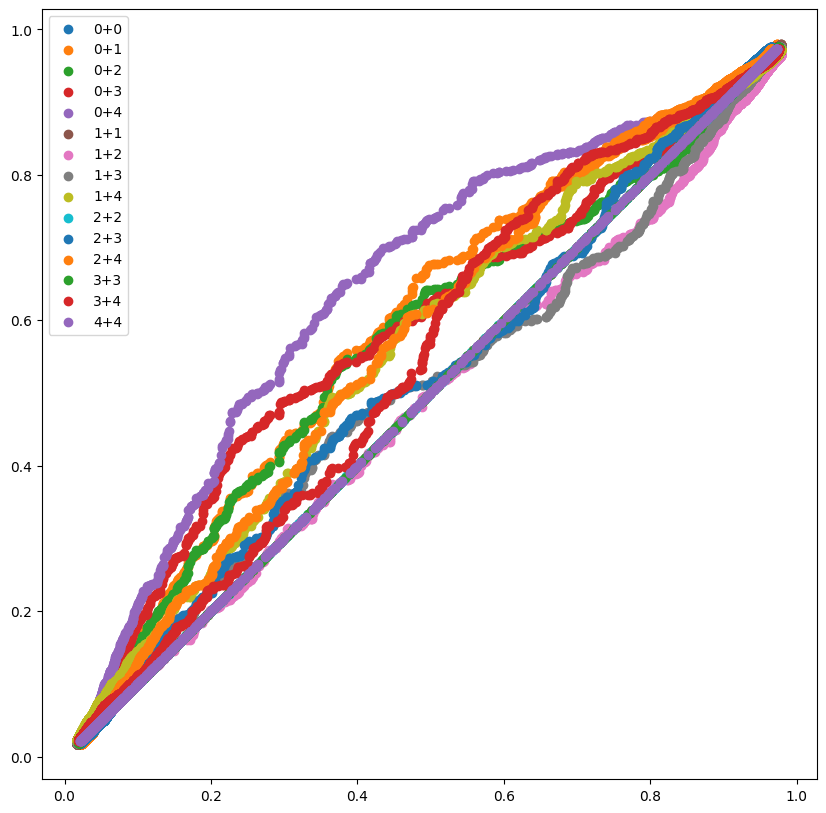

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(5):
    sigmoid_i = 1 / (1 + np.exp(-single_predictions[i]))[:, 0]
    inds = np.argsort(sigmoid_i)
    for j in range(i, 5):
        sigmoid_j = 1 / (1 + np.exp(-single_predictions[j]))[:, 0]
        plt.scatter(np.sort(sigmoid_i), np.sort(sigmoid_j), label='{}+{}'.format(i, j))
plt.legend()
plt.show()

In [ ]:
ensemble_predictions = np.array(single_predictions).sum(axis=0) / 5.0
sigmoid = 1 / (1 + np.exp(-ensemble_predictions))
eq_arc = accuracy_rejection(N=len(sigmoid), step=int(len(sigmoid)/10000), probs=np.max(sigmoid, axis=1), true_labels=true_labels, predicted_labels=predicted_labels)


def weighted_prediction(single_predictions, weights):
    weights = weights / weights.sum()
    return np.vstack((np.dot(weights, np.array(single_predictions)[:, :, 0]), np.dot(weights, np.array(single_predictions)[:, :, 1]))).T

weights = np.array([0.19009505, 0.19518455, 0.1502149 , 0.23677914, 0.22772636])
wp = weighted_prediction(single_predictions, weights)
sigmoid = 1 / (1 + np.exp(-wp))
wp_arc = accuracy_rejection(N=len(sigmoid), step=int(len(sigmoid)/10000), probs=np.max(sigmoid, axis=1), true_labels=true_labels, predicted_labels=predicted_labels)

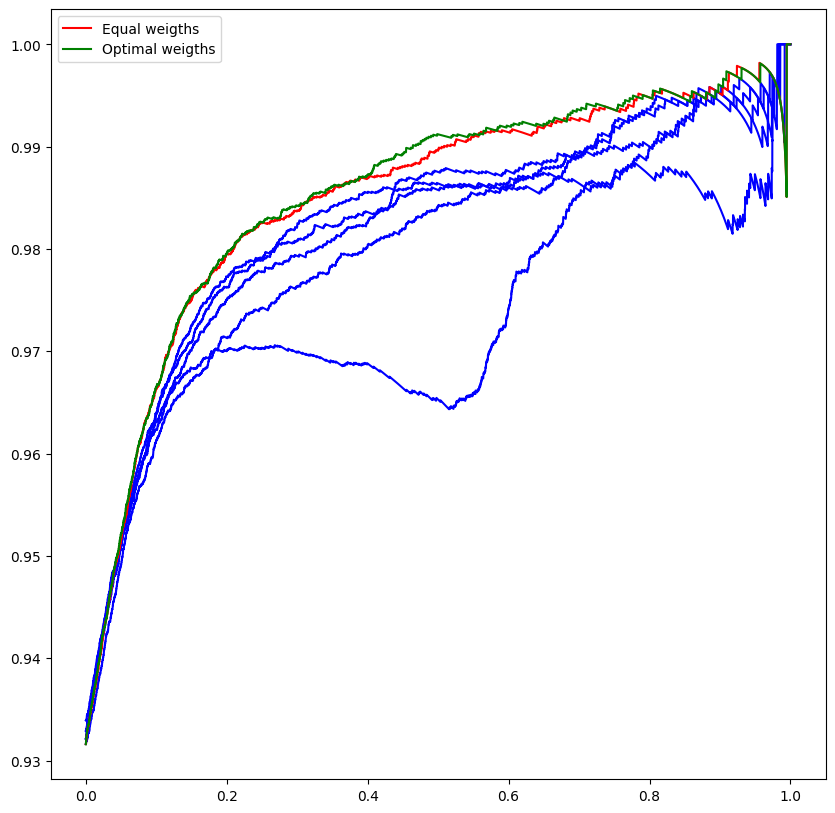

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(len(arc)):
    plt.plot(arc[i][0], arc[i][1], color='blue')

plt.plot(eq_arc[0], eq_arc[1], color='red', label='Equal weigths')
plt.plot(wp_arc[0], wp_arc[1], color='green', label='Optimal weigths')
plt.legend()
plt.show()
#plt.plot(range(len(arc[0])), arc[0])

In [ ]:
ensemble_predictions = np.array(single_predictions).sum(axis=0) / 5.0
ens_acc = accuracy_score(np.argmax(ensemble_predictions, axis=1), true_labels)
print('Ensemble accuracy equal weights', ens_acc)

Ensemble accuracy equal weights 0.9364


In [ ]:
weights = np.array([0.19009505, 0.19518455, 0.1502149 , 0.23677914, 0.22772636])
weighted_predictions = weighted_prediction(single_predictions, weights)
wp_ens_acc = accuracy_score(np.argmax(weighted_predictions, axis=1), true_labels)
print('Ensemble accuracy optimal weights', wp_ens_acc)

Ensemble accuracy optimal weights 0.9364


In [ ]:
print('Accuracy of single models')
for i in range(5):
  sng_acc = accuracy_score(np.argmax(single_predictions[i], axis=1), true_labels)
  print(sng_acc)

Accuracy of single models
0.93288
0.93216
0.93392
0.93208
0.9316


## Прямой подсчет апостериорной дисперсии

In [ ]:
def posterior_variance(predictions, true_labels, classes=2, t=10):
    pv = 0.0
    for cls in range(classes):
        preds = predictions[true_labels == cls]
        ps = []
        for i in range(t):
            inds = np.random.choice(np.arange(len(preds)), t)
            picked_preds = preds[inds, :]
            p = (picked_preds[:, cls] > picked_preds[:, (cls + 1) % 2]).sum()
            p /= float(t)
            ps.append(p)
        ps = np.array(ps)
        p_av = (preds[:, cls] > preds[:, (cls + 1) % 2]).mean()
        pv += ((p - p_av) ** 2).sum()
    pv /= classes
    return pv

In [ ]:
def posterior_expectation(predictions, true_labels, classes=2, t=10):
    pe = 0.0
    t_len = 100
    for i in range(t):
        ps = []
        for cls in range(classes):
            #preds = predictions[true_labels == cls]
            inds = np.random.choice(np.arange(len(predictions)), t_len)
            picked_preds = predictions[inds, :]
            p = picked_preds[:, cls].sum()
            p /= t_len
            ps.append(p)
        ps = max(ps)
        pe += (1 - ps)
    pe /= float(t)
    return pe

In [ ]:
sum_pe = 0.0
for i in range(5):
    print('Model', str(i + 1))
    sigmoid = 1 / (1 + np.exp(-single_predictions[i]))
    curr_pe = posterior_expectation(sigmoid, true_labels)
    print('PE =', round(curr_pe, 5))
    curr_acc = accuracy_score(np.argmax(single_predictions[i], axis=1), true_labels)
    print('Accuracy=', curr_acc)
    sum_pe += curr_pe
sum_pe /= 5.0
print('**************')
print('Total PE =', round(sum_pe, 5))

Model 1
PE = 0.48905
Accuracy= 0.93288
Model 2
PE = 0.50441
Accuracy= 0.93216
Model 3
PE = 0.4878
Accuracy= 0.93392
Model 4
PE = 0.4412
Accuracy= 0.93208
Model 5
PE = 0.47164
Accuracy= 0.9316
**************
Total PE = 0.47882


In [ ]:
sum_pv = 0.0
for i in range(5):
    print('Model', str(i + 1))
    sigmoid = 1 / (1 + np.exp(-single_predictions[i]))
    curr_pv = posterior_variance(sigmoid, true_labels)
    print('PV =', round(curr_pv, 5))
    curr_acc = accuracy_score(np.argmax(single_predictions[i], axis=1), true_labels)
    print('Accuracy=', curr_acc)
    sum_pv += curr_pv
sum_pv /= 5.0
print('**************')
print('Total PV =', round(sum_pv, 5))

Model 1
PV = 0.00166
Accuracy= 0.93288
Model 2
PV = 0.00368
Accuracy= 0.93216
Model 3
PV = 0.00369
Accuracy= 0.93392
Model 4
PV = 0.00109
Accuracy= 0.93208
Model 5
PV = 0.00337
Accuracy= 0.9316
**************
Total PV = 0.0027


# Подсчет апостериорной дисперсии через матрицу корреляции

In [ ]:
weights = np.array([0.19009505, 0.19518455, 0.1502149 , 0.23677914, 0.22772636])

def corr_based_posterior_variance(corr_matrix, weights):
    weights = np.expand_dims(weights, axis=0)
    pv = np.dot(np.dot(weights, corr_matrix), weights.T)
    return pv[0][0]

print('Equal weights PV', corr_based_posterior_variance(corr_matrix, np.array([1.0, 1.0, 1.0, 1.0, 1.0])/5.0))
print('Optimal weights PV', corr_based_posterior_variance(corr_matrix, weights))

Equal weights PV 0.8734309190744516
Optimal weights PV 0.8765992063195246


# Оптимизация различными методами

# Оптимизация через матрицу корреляции с ограничениями

In [ ]:
from cvxopt import matrix, solvers
from qpsolvers import solve_qp

In [ ]:
corr_matrix

array([[0.89077482, 0.92460434, 0.82636605, 0.88134123, 0.83642594],
       [0.92460434, 1.        , 0.87557732, 0.93458875, 0.88719799],
       [0.82636605, 0.87557732, 0.81474317, 0.85635497, 0.8018955 ],
       [0.88134123, 0.93458875, 0.85635497, 0.92873938, 0.85671176],
       [0.83642594, 0.88719799, 0.8018955 , 0.85671176, 0.83938789]])

In [ ]:
#P = matrix(2 * corr_matrix)
#q = matrix(np.zeros_like(corr_matrix[:, :1]))
#A = matrix(np.ones((1, corr_matrix.shape[0])))
#b = matrix(np.ones(1))
#lb = matrix(np.zeros(corr_matrix.shape[0]))
#ub = matrix(np.ones(corr_matrix.shape[0]))
P = 2 * corr_matrix
q = np.zeros_like(corr_matrix[:, :1])
A = np.ones((1, corr_matrix.shape[0]))
b = np.ones(1)
lb = np.zeros(corr_matrix.shape[0])
ub = np.ones(corr_matrix.shape[0])
x_sol = solve_qp(P, q, A=A, b=b, lb=lb, ub=ub, initvals=np.array([0.2, 0.2, 0.2, 0.2, 0.2]), solver='cvxopt', verbose=True)#, kktsolver='ldl', options={'kktreg':1e-3})
primal_obj = 0.5 * np.dot(np.dot(x_sol.T, P), x_sol)
eq_w = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
primal_obj_w = 0.5 * np.dot(np.dot(eq_w.T, P), eq_w)
print(x_sol)
print(primal_obj)
print(primal_obj_w)
#print(sol['x'], sol['primal objective'])

     pcost       dcost       gap    pres   dres
 0:  8.7343e-01 -4.1266e+00  1e+01  8e-01  4e+00
 1:  8.6338e-01  4.8230e-02  8e-01  1e-16  5e-16
 2:  8.5410e-01  7.7938e-01  7e-02  1e-16  3e-16
 3:  8.1404e-01  7.9755e-01  2e-02  2e-16  4e-16
 4:  8.1158e-01  8.1124e-01  3e-04  1e-16  5e-16
 5:  8.1147e-01  8.1146e-01  3e-06  2e-16  4e-16
 6:  8.1146e-01  8.1146e-01  3e-08  1e-16  7e-16
Optimal solution found.
[2.59442592e-07 1.37871995e-08 7.44782013e-01 5.38494732e-09
 2.55217709e-01]
0.811464232628519
0.8734309190744516


In [ ]:
optimal_weights = x_sol
ensemble_predictions = weighted_prediction(single_predictions, optimal_weights)
ens_acc = accuracy_score(np.argmax(ensemble_predictions, axis=1), true_labels)
print(round(ens_acc, 8))

0.93528


In [ ]:
optimal_weights

array([2.59442592e-07, 1.37871995e-08, 7.44782013e-01, 5.38494732e-09,
       2.55217709e-01])

In [ ]:
w = np.array([1., 1., 1., 1., 1.])
w = w / w.sum() #np.array([0.19009504, 0.19518454, 0.15021495, 0.23677912, 0.22772634])
np.dot(np.dot(w.T, corr_matrix), w)

0.8734309190744516

## Минимизация апостериорной дисперсии

In [ ]:
from bayes_opt import BayesianOptimization, UtilityFunction

In [ ]:
def black_box_function(w1, w2, w3, w4, w5):
    w = np.array([w1, w2, w3, w4, w5])
    if (w.sum() == 0):
        return -1
    w = w / w.sum()
    return -corr_based_posterior_variance(corr_matrix, w)

pbounds = {"w1": [0.0, 1.0], "w2": [0.0, 1.0], "w3": [0.0, 1.0], "w4": [0.0, 1.0], "w5": [0.0, 1.0]}
optimizer = BayesianOptimization(f = black_box_function,
                                 pbounds = pbounds, verbose = 5,
                                 random_state = 4)

In [ ]:
optimizer.maximize(init_points = 5, n_iter = 100)
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

|   iter    |  target   |    w1     |    w2     |    w3     |    w4     |    w5     |
-------------------------------------------------------------------------------------
| 1         | -0.8642   | 0.967     | 0.5472    | 0.9727    | 0.7148    | 0.6977    |
| 2         | -0.9217   | 0.2161    | 0.9763    | 0.00623   | 0.253     | 0.4348    |
| 3         | -0.8679   | 0.7794    | 0.1977    | 0.863     | 0.9834    | 0.1638    |
| 4         | -0.8354   | 0.5973    | 0.008986  | 0.3866    | 0.04416   | 0.9567    |
| 5         | -0.8921   | 0.4361    | 0.949     | 0.7863    | 0.8663    | 0.1732    |
| 6         | -0.8331   | 1.0       | 0.0       | 0.7855    | 0.0       | 1.0       |
| 7         | -0.8145   | 0.0       | 0.0       | 1.0       | 0.0       | 1.0       |
| 8         | -0.8459   | 0.0       | 0.0       | 1.0       | 1.0       | 1.0       |
| 9         | -0.8144   | 0.0       | 0.0       | 1.0       | 0.0       | 0.01338   |
| 10        | -0.8396   | 1.0       | 0.0       | 1.0 

In [ ]:
bayes = [0.0, 0.0, 1.0, 0.0, 0.34350920812624114]
#[0.6582128439035856, 0.8485724339736505, 0.5743632400093872, 0.9784273250515602, 0.7811624230287056]
bayes = np.array(bayes)
#np.array([0.7709616475639604, 0.7862128499691512, 0.6094084689849317, 0.9583737271302607, 0.9241483879188706])
bayes = bayes / bayes.sum()
print('Weights', bayes)
print('Uncertainty', corr_based_posterior_variance(corr_matrix, bayes))
ensemble_predictions = weighted_prediction(single_predictions, bayes)
ens_acc = accuracy_score(np.argmax(ensemble_predictions, axis=1), true_labels)
print('Accuracy', round(ens_acc, 8))

Weights [0.         0.         0.74431942 0.         0.25568058]
Uncertainty 0.8114642320199948
Accuracy 0.93528


In [ ]:
def black_box_function(w1, w2, w3, w4, w5):
    weights = np.array([w1, w2, w3, w4, w5])
    weights = weights / weights.sum()
    ensemble_predictions = np.vstack((np.dot(weights, np.array(single_predictions)[:, :, 0]), np.dot(weights, np.array(single_predictions)[:, :, 1]))).T
    ens_acc = accuracy_score(np.argmax(ensemble_predictions, axis=1), true_labels)
    return ens_acc

In [ ]:
pbounds = {"w1": [0.0, 1.0], "w2": [0.0, 1.0], "w3": [0.0, 1.0], "w4": [0.0, 1.0], "w5": [0.0, 1.0]}
optimizer = BayesianOptimization(f = black_box_function,
                                 pbounds = pbounds, verbose = 5,
                                 random_state = 4)

In [ ]:
optimizer.maximize(init_points = 5, n_iter = 100)
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

|   iter    |  target   |    w1     |    w2     |    w3     |    w4     |    w5     |
-------------------------------------------------------------------------------------
| 1         | 0.9362    | 0.967     | 0.5472    | 0.9727    | 0.7148    | 0.6977    |
| 2         | 0.9354    | 0.2161    | 0.9763    | 0.00623   | 0.253     | 0.4348    |
| 3         | 0.936     | 0.7794    | 0.1977    | 0.863     | 0.9834    | 0.1638    |
| 4         | 0.9357    | 0.5973    | 0.008986  | 0.3866    | 0.04416   | 0.9567    |
| 5         | 0.9363    | 0.4361    | 0.949     | 0.7863    | 0.8663    | 0.1732    |
| 6         | 0.9368    | 0.4742    | 0.9403    | 0.7261    | 0.8331    | 0.2002    |
| 7         | 0.9368    | 0.5343    | 0.9347    | 0.6816    | 0.7988    | 0.1633    |
| 8         | 0.9366    | 0.498     | 0.9248    | 0.626     | 0.7913    | 0.3155    |
| 9         | 0.9364    | 0.1908    | 0.9133    | 0.6885    | 0.4513    | 0.2203    |
| 10        | 0.9361    | 0.6486    | 0.2326    | 0.52

In [ ]:
bayes_acc = [0.3375944650789793, 0.9977460761947159, 0.4459910431596003, 0.4941768890565836, 0.9759401950591953]
# [0.5522155886070212, 0.814647765291938, 0.6594294004704345, 0.24886182964945547, 0.1841315041980888]
bayes_acc = np.array(bayes_acc) #[1.0, 1.0, 1.0, 0.16441734337821873, 0.31083513379670263])
bayes_acc /= bayes_acc.sum()
print('Weights', bayes_acc)
print('Uncertainty', corr_based_posterior_variance(corr_matrix, bayes_acc))
ensemble_predictions = weighted_prediction(single_predictions, bayes_acc)
ens_acc = accuracy_score(np.argmax(ensemble_predictions, axis=1), true_labels)
print('Accuracy', round(ens_acc, 8))

Weights [0.10382894 0.30686201 0.13716687 0.15198668 0.3001555 ]
Uncertainty 0.8827995935394732
Accuracy 0.9376


### Оптимизируем целевую функцию апостериорная дисперсия

In [ ]:
for i in range(5):
  print(posterior_variance(single_predictions[i], true_labels))

0.004706512701782091
0.02590257122083417
0.0019786596786228123
0.0020723535209777807
0.0023651083595907663


In [ ]:
posterior_variance(ensemble_predictions, true_labels)

0.0036830590257122047

In [ ]:
def black_box_function(w1, w2, w3, w4, w5):
    weights = np.array([w1, w2, w3, w4, w5])
    weights = weights / weights.sum()
    ensemble_predictions = np.vstack((np.dot(weights, np.array(single_predictions)[:, :, 0]), np.dot(weights, np.array(single_predictions)[:, :, 1]))).T
    pv = -posterior_variance(ensemble_predictions, true_labels)
    return pv

pbounds = {"w1": [0.0, 1.0], "w2": [0.0, 1.0], "w3": [0.0, 1.0], "w4": [0.0, 1.0], "w5": [0.0, 1.0]}
optimizer = BayesianOptimization(f = black_box_function,
                                 pbounds = pbounds, verbose = 5,
                                 random_state = 4)

In [ ]:
optimizer.maximize(init_points = 5, n_iter = 100)
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

|   iter    |  target   |    w1     |    w2     |    w3     |    w4     |    w5     |
-------------------------------------------------------------------------------------
| 1         | -0.0108   | 0.967     | 0.5472    | 0.9727    | 0.7148    | 0.6977    |
| 2         | -0.004241 | 0.2161    | 0.9763    | 0.00623   | 0.253     | 0.4348    |
| 3         | -0.01853  | 0.7794    | 0.1977    | 0.863     | 0.9834    | 0.1638    |
| 4         | -0.003488 | 0.5973    | 0.008986  | 0.3866    | 0.04416   | 0.9567    |
| 5         | -0.004125 | 0.4361    | 0.949     | 0.7863    | 0.8663    | 0.1732    |
| 6         | -0.0014   | 0.4742    | 0.9403    | 0.7261    | 0.8331    | 0.2002    |
| 7         | -0.001951 | 0.5044    | 0.9775    | 0.4971    | 0.6918    | 0.2738    |
| 8         | -0.003502 | 0.7627    | 1.0       | 0.559     | 0.9272    | 0.1848    |
| 9         | -0.004073 | 0.6645    | 1.0       | 0.7643    | 0.5203    | 0.1513    |
| 10        | -0.004166 | 0.6486    | 0.2326    | 0.52

In [ ]:
weights = [0.27322247335255545, 0.15757316181576198, 0.5300519859825109, 0.23363660668592545, 0.8227101885137785]
weights = np.array(weights)#[0.0, 1.0, 1.0, 1.0, 0.9974180288485169])
weights = weights / weights.sum()
print(weights)
print(corr_based_posterior_variance(corr_matrix, weights))
ensemble_predictions = np.vstack((np.dot(weights, np.array(single_predictions)[:, :, 0]), np.dot(weights, np.array(single_predictions)[:, :, 1]))).T
ens_acc = accuracy_score(np.argmax(ensemble_predictions, axis=1), true_labels)
ens_acc

[0.13544677 0.07811501 0.26276693 0.11582255 0.40784873]
0.8435611617808152


0.93568